#**Brain Cancer Segmentation**

#**All General Imports**

In [ ]:
# imports
import os
import cv2
import glob
import pdb
import json
import sys
import timeit
import platform 
import numpy as np
import matplotlib.pyplot as plt
from os.path import basename

#**Platform Settings**

In [ ]:
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

Colab Active:  True


#**All Keras Imports**

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

#**All Functions Definitions**

In [ ]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

#**All Data Downloads**

In [ ]:
start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

out = data_download("./brain_tumor_dataset_1.zip", "1IlfIKVCF2nnYndfZWsE7NHPE0si2bof1", OS)
out = data_download("./brain_tumor_dataset_2.zip", "1dYZ4GMfSeCEdnw-JqlgNUsMajHzLCqWp", OS)
print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  3.0212589289999414


#**Brain Tumor Classification**

#**All Globals**

In [ ]:
dataset_path = "./brain_tumor_dataset_2/Br35H-Mask-RCNN/"
predicted_images = "./predicted_images/"
train_folder = "TRAIN/"
val_folder = "VAL/"
test_folder = "TEST/"
annotations_train_file = dataset_path+train_folder+'annotations_train.json'
annotations_val_file = dataset_path+val_folder+'annotations_val.json'
annotations_test_file = dataset_path+test_folder+'annotations_test.json'
masks_train_folder = dataset_path+train_folder+'train_target_masks/'
masks_val_folder = dataset_path+val_folder+'val_target_masks/'
masks_test_folder = dataset_path+test_folder+'test_target_masks/'
input_data_type = "float"
target_data_type = "int"
n_rows_to_plot = 5
n_cols_to_plot = 5

#**Hyperparameters**

In [ ]:
neural_model = 'brain_unet'
epochs = 100
batch_size = 32
width = 256
height = 256
channels = 1
summary = False

#**Initializations**

In [ ]:
np.random.seed(42)
folders = [dataset_path+train_folder, dataset_path+val_folder, dataset_path+test_folder]
masks_folders = [masks_train_folder, masks_val_folder, masks_test_folder]

#**Mounting Google Drive via Code**

In [ ]:
if colab_active is True: 
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.append('/content/drive/My Drive')
  model_path = "/content/drive/MyDrive/DL_Models/"
  if os.path.isdir(model_path) is False: 
    os.makedirs(model_path) 
else: 
  model_path = "./"

Mounted at /content/drive


#**Functions Definitions**

In [ ]:
def json_to_masks(annotations_path, masks_folder):
  ''' 
  Converts Json Annotations Files into Img annotation Masks 
  '''

  with open(annotations_path) as json_file:
      data = json.load(json_file)

  images_path = dataset_path+train_folder
  train_images = glob.glob(images_path + "*.jpg")

  for img in train_images:
    image = cv2.imread(img)
    dimensions = image.shape
    file_name = basename(img).split('.')[0]
    tmp = np.zeros(dimensions).astype('uint8')
    for d in data:
        if file_name == data[d]['filename'].replace(".jpg",""):
            if len(data[d]['regions'][0]['shape_attributes']) == 3:
                x_pixels = data[d]['regions'][0]['shape_attributes']['all_points_x']
                y_pixels = data[d]['regions'][0]['shape_attributes']['all_points_y']
                pts = []
                for i in range(len(x_pixels)):
                    pts.append([x_pixels[i], y_pixels[i]])
                ptss = np.array(pts)
                ptss = ptss.reshape((-1, 1, 2))
                isClosed = True
                tmp = cv2.fillPoly(tmp, [ptss], (255,255,255))
            elif len(data[d]['regions'][0]['shape_attributes']) == 6:
                center_coordinates = (data[d]['regions'][0]['shape_attributes']['cx'],
                                      data[d]['regions'][0]['shape_attributes']['cy'])
                axesLength = (int(data[d]['regions'][0]['shape_attributes']['rx']),
                              int(data[d]['regions'][0]['shape_attributes']['ry']))
                angle = data[d]['regions'][0]['shape_attributes']['theta']
                startAngle = 0
                endAngle = 360
                tmp = cv2.ellipse(tmp,
                                  center_coordinates,
                                  axesLength,
                                  angle,
                                  startAngle,
                                  endAngle,
                                  (255,255,255),
                                  thickness=-1)

    cv2.imwrite("{}.png".format(masks_folder+file_name), tmp.astype('uint8'))

def read_images(folders, is_mask = False): 
  ''' 
  Reads all the Input or Masks Images
  '''
  datasets = []
  for f in folders: 
    if is_mask is False: 
      images = glob.glob(f+"*.jpg")
    else: 
      images = glob.glob(f+"*.png")

    images.sort()
    dataset = []
    for img in images:
      image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
      image = image / 255
      image = cv2.resize(image, (width, height))
      if is_mask is True:
        image[image != 0] = 1
      dataset.append(image)

    datasets.append(dataset)

  return datasets

def data_shuffle(data_x, data_y): 
  ''' 
  Data Shuffle
  '''
 
  indices = np.arange(data_x.shape[0])
  np.random.shuffle(indices)
  data_x = data_x[indices]
  data_y = data_y[indices]
  
  return (data_x, data_y) 

def plot_images(dataset, n_rows_to_plot = 3, n_cols_to_plot = 5):
  fig = plt.figure(figsize=(10,5))
  i = 0
  for im in dataset: 
      plt.axis("off")
      ax = fig.add_subplot(n_rows_to_plot, n_cols_to_plot, 1 + i, xticks=[], yticks=[])
      plt.imshow(im, cmap = "gray")
      i += 1
      if i >= n_rows_to_plot*n_cols_to_plot: 
        break
  plt.show()


def jacard(y_true, y_pred):
    y_true_c = K.flatten(y_true)
    y_pred_c = K.flatten(y_pred)
    intersection = K.sum(y_true_c * y_pred_c)
    return (intersection + 1.0) / (K.sum(y_true_c) + K.sum(y_pred_c) - intersection + 1.0) 

def jacard_loss(y_true, y_pred):
    return -jacard(y_true,y_pred)

#**Preprocessing**

In [ ]:
datasets  = read_images(folders)

train_set_x, val_set_x, test_set_x = datasets

train_set_x = np.asarray(train_set_x).astype(input_data_type)
val_set_x = np.asarray(val_set_x).astype(input_data_type)
test_set_x = np.asarray(test_set_x).astype(input_data_type)

#**Target Generation Converting Annotations into Masks**

Creates the masks folders if not present. If masks are not present, the masks generation process will start, otherwise, it will take already generated masks. 

In [ ]:
if os.path.isdir(masks_train_folder) is False: 
  os.makedirs(masks_train_folder) 
  json_to_masks(annotations_train_file, masks_train_folder)

if os.path.isdir(masks_val_folder) is False: 
  os.makedirs(masks_val_folder) 
  json_to_masks(annotations_val_file, masks_val_folder)

if os.path.isdir(masks_test_folder) is False: 
  os.makedirs(masks_test_folder) 
  json_to_masks(annotations_test_file, masks_test_folder)

datasets  = read_images(masks_folders, True)

train_set_y, val_set_y, test_set_y = datasets

train_set_y = np.asarray(train_set_y).astype(target_data_type)
val_set_y = np.asarray(val_set_y).astype(target_data_type)
test_set_y = np.asarray(test_set_y).astype(target_data_type)

#**Data Shuffle**

In [ ]:
train_set_x, train_set_y = data_shuffle(train_set_x, train_set_y)
val_set_x, val_set_y = data_shuffle(val_set_x, val_set_y)
test_set_x, test_set_y = data_shuffle(test_set_x, test_set_y)

print("Train X Shape: ", train_set_x.shape)
print("Train Y Shape: ", train_set_y.shape)
print("Val X Shape: ", val_set_x.shape)
print("Val Y Shape: ", val_set_y.shape)
print("Test X Shape: ", test_set_x.shape)
print("Test Y Shape: ", test_set_y.shape)

Train X Shape:  (500, 256, 256)
Train Y Shape:  (500, 256, 256)
Val X Shape:  (201, 256, 256)
Val Y Shape:  (201, 256, 256)
Test X Shape:  (100, 256, 256)
Test Y Shape:  (100, 256, 256)


#**Dataset Sample Visualization**

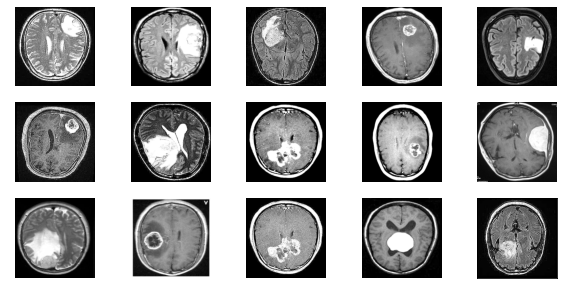

In [ ]:
if OS!="Linux" or colab_active is True:
  plot_images(train_set_x, n_rows_to_plot, n_cols_to_plot)

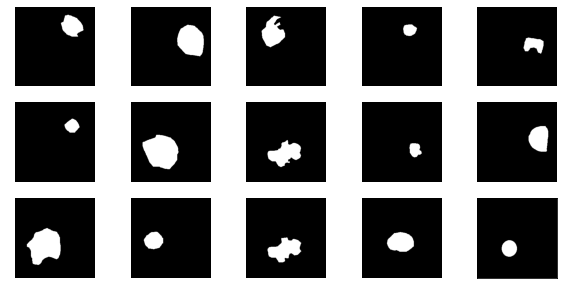

In [ ]:
if OS!="Linux" or colab_active is True:
  plot_images(train_set_y, n_rows_to_plot, n_cols_to_plot)

#**Data Reshaping for the Training**

In [ ]:
train_set_x = np.reshape(train_set_x, (len(train_set_x), height, width, channels))
train_set_y = np.reshape(train_set_y, (len(train_set_y), height, width, channels))

#**Model Definitions**

#**Segmentation Model Definition: Unet**

In [ ]:
def unet(n_classes=2, height=256, width=256, channels=1, metrics = ['accuracy']):
    inputs = Input((height, width, channels))

    #Contraction path
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)  
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)  
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
     
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D((2, 2))(conv_3)
     
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.1)(conv_4)
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
     
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
    conv_5 = Dropout(0.2)(conv_5)
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
    u6 = concatenate([u6, conv_4])
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
    u7 = concatenate([u7, conv_3])
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    conv_7 = Dropout(0.1)(conv_7)
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
    u8 = concatenate([u8, conv_2])
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)  
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    u9 = concatenate([u9, conv_1], axis=3)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)
     
    if n_classes == 2: 
      outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv_9)
    elif n_classes > 2: 
      outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    if n_classes == 2: 
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = metrics)
    elif n_classes > 2: 
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = metrics)

    if summary: 
      model.summary()
    
    return model


#**Model Compiling**

In [ ]:
metrics=['accuracy', jacard]
n_classes = len(np.unique(train_set_y))        # Detect the number of classes within the target
brain_unet = unet(n_classes=n_classes, height = height, width = width, channels = channels, metrics = metrics)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_26 (Conv2D)             (None, 32, 32, 128)  147584      ['dropout_12[0][0]']             
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 128)  0          ['conv2d_26[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 16, 16, 256)  295168      ['max_pooling2d_7[0][0]']        
                                                                                                  
 dropout_13 (Dropout)           (None, 16, 16, 256)  0           ['conv2d_27[0][0]']              
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 256)  590080      ['dropout_13[0][0]']             
          

In [ ]:
#brain_unet.fit(train_set_x, train_set_y, validation_data = (val_set_x, val_set_y), epochs = epochs, batch_size = batch_size)
brain_unet.fit(train_set_x, train_set_y, validation_split = 0.2, epochs = epochs, batch_size = batch_size)

Epoch 1/100
13/13 [==============================] - 13s 677ms/step - loss: 0.6846 - accuracy: 0.5883 - jacard: 0.0480 - val_loss: 0.6573 - val_accuracy: 0.8913 - val_jacard: 0.0511
Epoch 2/100
13/13 [==============================] - 8s 632ms/step - loss: 0.6417 - accuracy: 0.8301 - jacard: 0.0454 - val_loss: 0.6160 - val_accuracy: 0.9288 - val_jacard: 0.0480
Epoch 3/100
13/13 [==============================] - 8s 634ms/step - loss: 0.5282 - accuracy: 0.8529 - jacard: 0.0342 - val_loss: 0.4413 - val_accuracy: 0.9393 - val_jacard: 0.0364
Epoch 4/100
13/13 [==============================] - 8s 636ms/step - loss: 0.3689 - accuracy: 0.9337 - jacard: 0.0185 - val_loss: 0.3972 - val_accuracy: 0.9414 - val_jacard: 0.0391
Epoch 5/100
13/13 [==============================] - 8s 635ms/step - loss: 0.2754 - accuracy: 0.9443 - jacard: 0.0261 - val_loss: 0.2848 - val_accuracy: 0.9416 - val_jacard: 0.0541
Epoch 6/100
13/13 [==============================] - 8s 636ms/step - loss: 0.2027 - accuracy: 

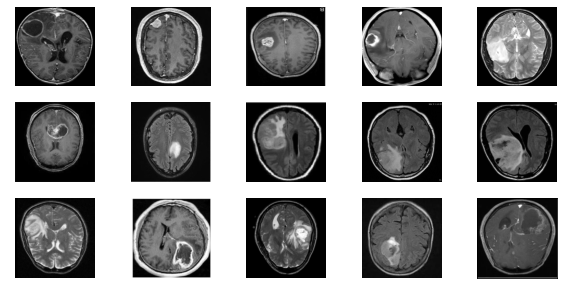

In [ ]:
if OS!="Linux" or colab_active is True:
  plot_images(test_set_x, n_rows_to_plot, n_cols_to_plot)

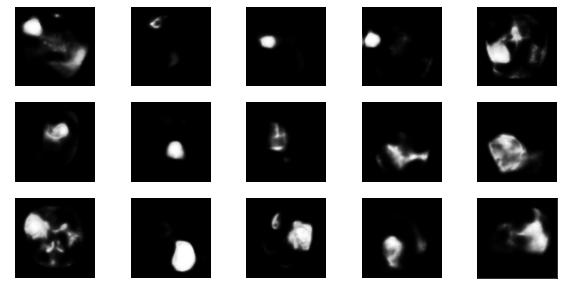

In [ ]:
pred_list = []
for t in test_set_x:
  brain_predicted =  (np.reshape(brain_unet.predict(np.reshape(t, (1, 256, 256, 1))), (256, 256)).astype(np.float32) * 255).astype("uint8")
  pred_list.append(brain_predicted)

if OS!="Linux" or colab_active is True:
  plot_images(pred_list, n_rows_to_plot, n_cols_to_plot)

In [ ]:
brain_unet.save_weights(model_path+"brain_segmentation_last_model.h5")
model_json = brain_unet.to_json()
with open(model_path+"brain_segmentation_last_model.json", "w") as json_file: 
  json_file.write(model_json)

Brain Segmentation Unet Loaded Successfully...


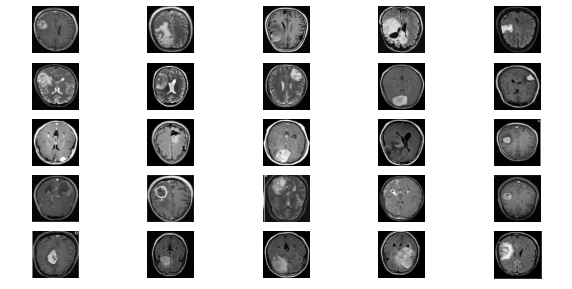

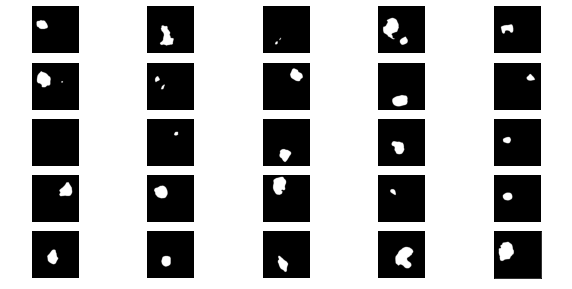

(256, 256)
(256, 256, 3)


'\nt_path = "/BTproject/Test/"\nt_images = glob.glob(t_path + "*.jpg")\nt_images.sort()\n\nfor img in t_images:\n   image = cv2.imread(img)\n   rows, cols, channels = image.shape   \n   \n   tmp = cv2.imread(img, cv2.IMREAD_GRAYSCALE)    \n   tmp = tmp / 255\n   tmp = trans.resize(tmp,(256,256))\n   predicted = BTfinder.predict(np.reshape(tmp, (1, 256, 256, 1)))\n   predicted = predicted.astype(np.float64) * 255\n   predicted = np.reshape(predicted, (256, 256))\n   predicted = trans.resize(predicted, (rows,cols))\n   predicted = predicted.astype(np.uint8)\n   predicted = cv2.cvtColor(predicted, cv2.COLOR_GRAY2BGR)\n   \n   ret, mask = cv2.threshold(predicted, 120, 255, cv2.THRESH_BINARY)\n   white_pixels = np.where((mask[:, :, 0] == 255) & \n                           (mask[:, :, 1] == 255) & \n                           (mask[:, :, 2] == 255))\n   mask[white_pixels] = [0, 0, 255]\n   add = cv2.addWeighted(image, 0.9, mask, 0.7, 0)   \n   \n   file_name = str(img).replace("/BTproject/T

In [ ]:
with open(model_path+"brain_segmentation_last_model.json", 'r') as json_file:
    loaded_model_json = json_file.read()
brain_unet = model_from_json(loaded_model_json)
brain_unet.load_weights(model_path+"brain_segmentation_last_model.h5")
print("Brain Segmentation Unet Loaded Successfully...")

brain_unet.compile(optimizer = Adam(), loss = 'binary_crossentropy')
if summary: 
  brain_unet.summary()

test_set = []
pred_list_ov = []
mask_list = []
if os.path.isdir(predicted_images) is False: 
  os.makedirs(predicted_images) 
images = glob.glob(dataset_path+test_folder+"*.jpg")
images.sort()
for i in range(len(images)):
  image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
  image = image / 255
  image = cv2.resize(image, (width, height))
  test_set.append(image)
  file_name = basename(images[i]).split('.')[0]
  brain_predicted =  (np.reshape(brain_unet.predict(np.reshape(image, (1, 256, 256, 1))), (256, 256)).astype(np.float32) * 255).astype("uint8")
  brain_predicted = cv2.cvtColor(brain_predicted, cv2.COLOR_GRAY2BGR)
  ret, mask = cv2.threshold(brain_predicted, 120, 255, cv2.THRESH_BINARY)
  #mask_2 = mask.copy()
  #mask_2 = mask
  white_pixels = np.where((mask[:, :, 0] == 255) & (mask[:, :, 1] == 255) & (mask[:, :, 2] == 255))
  mask[white_pixels] = [255, 255, 255]
  #mask_2[white_pixels] = [0, 255, 0]
  #mask_2 = mask[:,:,0].astype('float64')
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #overlap = cv2.addWeighted(image, 0.9, mask_2, 0.7, 0)   

  mask_list.append(mask)
  #pred_list_ov.append(overlap)
  cv2.imwrite(predicted_images+file_name+"_mask.png", mask)
  #cv2.imwrite(predicted_images+file_name+"_overlapped_mask.png", mask)

if OS!="Linux" or colab_active is True:
  plot_images(test_set, n_rows_to_plot, n_cols_to_plot)
  plot_images(mask_list, n_rows_to_plot, n_cols_to_plot)
  #plot_images(pred_list_ov, n_rows_to_plot, n_cols_to_plot)

print(image.shape)
print(mask.shape)
#print(mask_2.shape)

'''
  pred_list_ov.append(overlap)

plot_images(pred_list_ov, n_rows_to_plot, n_cols_to_plot)
'''

'''
t_path = "/BTproject/Test/"
t_images = glob.glob(t_path + "*.jpg")
t_images.sort()

for img in t_images:
   image = cv2.imread(img)
   rows, cols, channels = image.shape   
   
   tmp = cv2.imread(img, cv2.IMREAD_GRAYSCALE)    
   tmp = tmp / 255
   tmp = trans.resize(tmp,(256,256))
   predicted = BTfinder.predict(np.reshape(tmp, (1, 256, 256, 1)))
   predicted = predicted.astype(np.float64) * 255
   predicted = np.reshape(predicted, (256, 256))
   predicted = trans.resize(predicted, (rows,cols))
   predicted = predicted.astype(np.uint8)
   predicted = cv2.cvtColor(predicted, cv2.COLOR_GRAY2BGR)
   
   ret, mask = cv2.threshold(predicted, 120, 255, cv2.THRESH_BINARY)
   white_pixels = np.where((mask[:, :, 0] == 255) & 
                           (mask[:, :, 1] == 255) & 
                           (mask[:, :, 2] == 255))
   mask[white_pixels] = [0, 0, 255]
   add = cv2.addWeighted(image, 0.9, mask, 0.7, 0)   
   
   file_name = str(img).replace("/BTproject/Test\\", "")
   file_name = file_name.replace(".jpg", "")
   cv2.imwrite('/BTproject/Test/{}predicted.png'.format(file_name),
               add)
'''

In [ ]:
mask_2.dtype

dtype('float64')

In [ ]:
image.dtype

dtype('float64')